In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [28]:
def get_4_points(n):
  # function to get the 4 points to be used to generate 5 pairs of perpendicular lines
  if n==1:
    P=[117,586]   #x1,y1
    Q=[394,621]  #x2,y2
    R=[408,388] #x3,y3
    S=[146,334]  #x4,y4
  if n==2:
    P=[369,548]
    Q=[361,853]
    R=[644,973]
    S=[618,510]
  if n==3:  
    P=[2092,1481]   #x1,y1
    Q=[2693,1322] #x2,y2
    R=[2667,717] #x3,y3
    S=[2057,700]  #x4,y4
  return P,Q,R,S

In [18]:
def get_perpendicular_lines(P,Q,R,S):
  #get the homogeneous coordinates
  P_homo=np.array(P)
  P_homo=np.append(P_homo,1)
  Q_homo=np.array(Q)
  Q_homo=np.append(Q_homo,1)
  R_homo=np.array(R)
  R_homo=np.append(R_homo,1)
  S_homo=np.array(S)
  S_homo=np.append(S_homo,1)

  #find the 5 perpendicular line pairs
  l1=np.cross(P_homo,Q_homo)  #pl1
  l1=l1/l1[2]
  m1=np.cross(Q_homo,R_homo)  #pl1
  m1=m1/m1[2]

  l2=np.cross(Q_homo,R_homo)  #pl2
  l2=l2/l2[2]
  m2=np.cross(R_homo,S_homo)  #pl2
  m2=m2/m2[2]

  l3=np.cross(R_homo,S_homo)  #pl3
  l3=l3/l3[2]
  m3=np.cross(S_homo,P_homo)  #pl3
  m3=m3/m3[2]

  l4=np.cross(S_homo,P_homo)  #pl4
  l4=l4/l4[2]
  m4=np.cross(P_homo,Q_homo)  #pl4
  m4=m4/m4[2]

  l5=np.cross(P_homo,R_homo)  #pl5
  l5=l5/l5[2]
  m5=np.cross(Q_homo,S_homo)  #pl5
  m5=m5/m5[2]

  return l1,l2,l3,l4,l5,m1,m2,m3,m4,m5

In [29]:
def get_H(l1,l2,l3,l4,l5,m1,m2,m3,m4,m5):

  #get a 5x6 matrix corresponding to the equation
  A=np.zeros((5,6))
  A[0]=[l1[0]*m1[0],(l1[1]*m1[0]+l1[0]*m1[1])/2,l1[1]*m1[1],(l1[0]*m1[2]+l1[2]*m1[0])/2,(l1[1]*m1[2]+l1[2]*m1[1])/2,l1[2]*m1[2]]
  A[1]=[l2[0]*m2[0],(l2[1]*m2[0]+l2[0]*m2[1])/2,l2[1]*m2[1],(l2[0]*m2[2]+l2[2]*m2[0])/2,(l2[1]*m2[2]+l2[2]*m2[1])/2,l2[2]*m2[2]]
  A[2]=[l3[0]*m3[0],(l3[1]*m3[0]+l3[0]*m3[1])/2,l3[1]*m3[1],(l3[0]*m3[2]+l3[2]*m3[0])/2,(l3[1]*m3[2]+l3[2]*m3[1])/2,l3[2]*m3[2]]
  A[3]=[l4[0]*m4[0],(l4[1]*m4[0]+l4[0]*m4[1])/2,l4[1]*m4[1],(l4[0]*m4[2]+l4[2]*m4[0])/2,(l4[1]*m4[2]+l4[2]*m4[1])/2,l4[2]*m4[2]]
  A[4]=[l5[0]*m5[0],(l5[1]*m5[0]+l5[0]*m5[1])/2,l5[1]*m5[1],(l5[0]*m5[2]+l5[2]*m5[0])/2,(l5[1]*m5[2]+l5[2]*m5[1])/2,l5[2]*m5[2]]
  
  #need to find the null vector for the A matrix. Will make use of sympy library
  from sympy import Matrix 
  a=Matrix(A)
  c=a.nullspace()
  c=np.array(c).astype(np.int)
  c=c/max(c[0]) 

  #get the S matrix from c
  S_mat = np.zeros((2,2))
  S_mat[0,0] = c[0][0]
  S_mat[1,0] = 0.5 * c[0,1]
  S_mat[0,1] = 0.5 * c[0,1]
  S_mat[1,1] = c[0,2]

 
  #take the svd of S to define A
  U, D, Vt = np.linalg.svd(S_mat)

  A = np.zeros((2,2))
  D_sq = np.diag(np.sqrt(D))
  A = np.dot(Vt, np.dot(D_sq, Vt))
  v = np.zeros((2,1))
  rhs_vA = np.zeros((2,1))
  rhs_vA [0] = 0.5 * c[0,3]
  rhs_vA [1] = 0.5 * c[0,4]

  v = np.dot(np.linalg.inv(A), rhs_vA)
  H = np.zeros((3,3),dtype=np.float)

  #Filling up the homography
  H[0]=np.array([A[0,0], A[0,1], 0],dtype=np.float)
  H[1]=np.array([A[1,0], A[1,1], 0],dtype=np.float)
  H[2]=np.array([v[0], v[1], 1],dtype=np.float)

  print("H: ",H)
  H_inv = np.linalg.inv(H)
  return H,H_inv

In [22]:
def get_new_coords(img,H):
  # this function returns the size of the image in the world coordinates after transformation

  width=img.shape[1]
  height=img.shape[0]
  print("width(x)=",width)
  print("height(y)=",height)

  img_coords=np.array([[0,0,1],[0,height,1],[width,0,1],[width,height,1]])  # 4 corners of the image in homogenous coordinates
  print("image coordinates: ",img_coords.T)

  new_coords=np.matmul(H,img_coords.T)  
  new_coords=new_coords/new_coords[2]
  new_coords=np.rint(new_coords).astype(int)
  new_img_coords=new_coords.T[:,:2]
  print("new image coordinates: ",new_img_coords)
  return new_img_coords

def get_mapped_image(im1, new_img_coords,H_inv):
  '''
  We can see from the projected corner points that the origin in this new coordinate is not at (0,0). Hence we need 
  to find the appropriate translation to bring the coordinates along origin.  
  
  Also we need to scale the image so that the final image size is not very large.
  '''
  height,width,_ = im1.shape
  scale1=width/(max(new_img_coords[:,0])-min(new_img_coords[:,0]))  # get a sale along the width (actual width/project_width)
  scale2=height/(max(new_img_coords[:,1])-min(new_img_coords[:,1])) # get a sale along the height (actual height/project_height)
  scale=max(scale1, scale2)   # select the max value as the scale for both width and height (or can use different scales)
  print("scale: ",scale)

  #find the translation to bring the coordinates to positive values
  tx=np.round(np.min(new_img_coords[:,0]))
  ty=np.round(np.min(new_img_coords[:,1]))
  print("tx,ty",tx,ty)

  '''
  Find out the shape of the new image in world coordinates.
  '''

  new_height=np.round((max(new_img_coords[:,1])-min(new_img_coords[:,1]))*scale2).astype(int)
  new_width=np.round((max(new_img_coords[:,0])-min(new_img_coords[:,0]))*scale1).astype(int)
  
  new_image=np.zeros((new_height,new_width,3))

  max_X=im1.shape[1]    # this value will be used to check if the mapped pixels are within the range of the original image so that pixel values are present for them 
  max_Y=im1.shape[0]

  '''
  To find the mapping of every point in the new image to the distorted image, we multiply every point with the inverse
  of the Homography - i.e. map every point in real world coordinates to the image plane and find the correspondence.
  '''
  
  for i in range(0,new_width):  #x
    for j in range(0,new_height): #y

      k1=i/scale1+tx
      k2=j/scale2+ty
      init=np.array((k1,k2,1))
      mapped=np.matmul(H_inv,init)
      mapped=np.rint(mapped/mapped[2])
      mapped=mapped.astype(int)
      if mapped[0]>=0 and mapped[0]<max_X and mapped[1]>=0 and mapped[1]<max_Y:
        new_image[j,i]=im1[mapped[1],mapped[0]]
  
  return new_image.astype(int)

In [34]:
def Rectification(img_num):
  # wrapper function to carry out the rectification process..
  print("current image: ",img_num)
  if img_num ==1:
    image=cv2.imread("/content/drive/My Drive/hw3_Task1_Images/Images/Img1.JPG")
  elif img_num ==2:
    image=cv2.imread("/content/drive/My Drive/hw3_Task1_Images/Images/Img2.jpeg")
  elif img_num ==3:
    image=cv2.imread("/content/drive/My Drive/hw3_Task1_Images/Images/Img3.JPG")
  image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  im1 = np.copy(image_orig)
  plt.figure()
  plt.imshow(im1)
  plt.title("Original Image")

  P,Q,R,S = get_4_points(img_num)
  l1,l2,l3,l4,l5,m1,m2,m3,m4,m5 = get_perpendicular_lines(P,Q,R,S)
  H,H_inv = get_H(l1,l2,l3,l4,l5,m1,m2,m3,m4,m5)
  new_coords = get_new_coords(im1,H_inv)
  mapped_img = get_mapped_image(im1,new_coords,H)
  plt.figure()
  plt.imshow(mapped_img)
  plt.title("Rectified Image")

current image:  1
H:  [[ 9.93255521e-01  1.15945982e-01  0.00000000e+00]
 [ 1.15945982e-01  7.90111529e-01  0.00000000e+00]
 [ 3.26439262e-04 -9.25739097e-05  1.00000000e+00]]
width(x)= 1600
height(y)= 1200
image coordinates:  [[   0    0 1600 1600]
 [   0 1200    0 1200]
 [   1    1    1    1]]
new image coordinates:  [[   0    0]
 [-150 1286]
 [3702 -543]
 [2263 2024]]
scale:  0.4674717569146864
tx,ty -150 -543
current image:  2
H:  [[ 8.45910201e-02 -2.03157496e-01  0.00000000e+00]
 [-2.03157496e-01  9.79146073e-01  0.00000000e+00]
 [-1.05656463e-03  2.57373785e-04  1.00000000e+00]]
width(x)= 768
height(y)= 1024
image coordinates:  [[   0    0  768  768]
 [   0 1024    0 1024]
 [   1    1    1    1]]
new image coordinates:  [[  0   0]
 [870 362]
 [945 196]
 [966 244]]
scale:  2.8287292817679557
tx,ty 0 0
current image:  3
H:  [[9.93481170e-01 1.13996340e-01 0.00000000e+00]
 [1.13996340e-01 5.77003414e-01 0.00000000e+00]
 [2.09102578e-04 1.96200439e-05 1.00000000e+00]]
width(x)= 3840

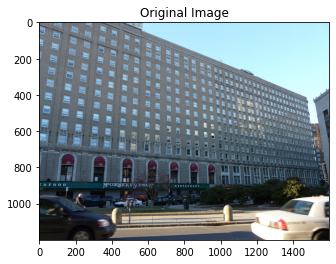

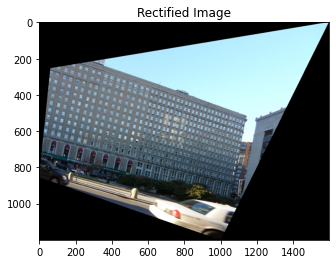

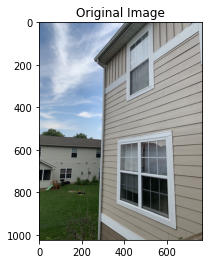

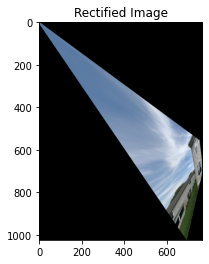

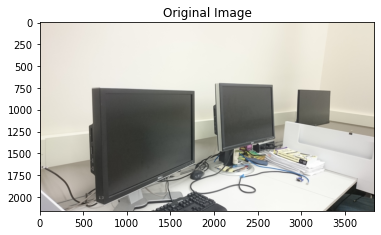

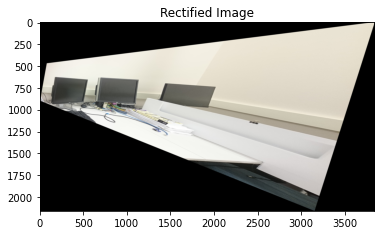

In [35]:
Rectification(1)
Rectification(2)
Rectification(3)